In [ ]:
import numpy as np
import torch
from matplotlib import pyplot as plt
import os
import cv2
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
from copy import deepcopy
from typing import Union, Callable, List, Tuple
import json
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [ ]:
!pip install torchimize

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.7/41.7 kB 1.2 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
downloads_path = "/content/gdrive/My Drive/"

In [ ]:
class utils:
    @classmethod
    def check_shape(cls, tensor, shape):
        tensor_size = tensor.size()
        for i in range(len(shape)):
            assert(tensor_size[i] == shape[i])

    @classmethod
    def check_type(cls, tensor, dtype):
        assert(tensor.dtype == dtype)

    @classmethod
    def check_tensor(cls, tensor, shape=None, dtype=None):
        if shape is not None:
            cls.check_shape(tensor, shape)
        if dtype is not None:
            cls.check_type(tensor, dtype)

    @classmethod
    def get_base_imgs(cls, cam_names, base_img_dir):
        base_images = []
        for cam_name in cam_names:
            base_img_path = base_img_dir+"camera_"+cam_name+"_base_img.png"
            base_img = cv2.imread(base_img_path)
            base_img = cv2.cvtColor(base_img, cv2.COLOR_BGR2GRAY)
            base_img = base_img.astype("float32",copy=False)
            base_img /= np.max(base_img)
            base_images.append(base_img)
        return base_images

    @classmethod
    def to_numpy(cls, thing):
        if isinstance(thing, np.ndarray):
            return thing
        elif torch.is_tensor(thing):
            return thing.detach().cpu().numpy()
        elif isinstance(thing, list):
            return np.array(thing)
        else:
            raise TypeError("Please pass a list, tensor, or ndarray.")


In [ ]:
class Camera:
    def __init__(self, name, image_shape, K, D, fisheye,  base_img, distort=True, Transform=None, px_cutoff=0.5):
        self.name = name
        self.image_shape = image_shape
        self.set_K(K)
        self.set_D(D)
        self.fisheye = fisheye
        self.base_img = torch.from_numpy(base_img)
        self.should_distort = distort
        if Transform is None:
            self.set_T(torch.randn(4,4), dtype=torch.double)
        else:
            self.set_T(Transform)
        self.update_cam_pos()
        self.px_cutoff = px_cutoff

    def set_T(self, new_T):
        utils.check_tensor(new_T, shape=[4,4], dtype=torch.double)
        self.T = new_T

    def get_T(self):
        T = self.T
        return T

    def set_K(self, new_K):
        utils.check_tensor(new_K, shape=[3,3], dtype=torch.double)
        self.K = new_K

    def get_K(self):
        return self.K

    def set_D(self, new_D):
        utils.check_tensor(new_D, dtype=torch.double)
        self.D = new_D

    def get_D(self):
        return self.D

    def get_R_mx(self):
        return self.get_T()[0:3,0:3]

    def get_R_vec(self):
        R_vec = torch.from_numpy(cv2.Rodrigues(utils.to_numpy(self.get_R_mx()))[0])
        return R_vec

    def get_T_vec(self):
        T_vec = self.get_T()[0:3,3:4]
        return T_vec

    def update_cam_pos(self):
        self.cam_pos = torch.matmul((-1 * self.get_R_mx().t()), self.get_T_vec())

    def distort(self, points):
        x = points[:, 0]
        y = points[:, 1]
        r = torch.sqrt(torch.square(x) + torch.square(y))
        theta = torch.atan(r)
        theta2 = theta**2
        theta4 = theta2**2
        theta6 = theta2**3
        theta8 = theta4**2
        D_mx = self.get_D()
        theta_d = theta * (1 +
                           (D_mx[0].item() * theta2) +
                           (D_mx[1].item() * theta4) +
                           (D_mx[2].item() * theta6) +
                           (D_mx[3].item() * theta8)
                           )
        x_dist = (theta_d / r) * x
        y_dist = (theta_d / r) * y
        dist_pts = torch.stack((x_dist,y_dist), dim=1)
        dist_pts[torch.isnan(dist_pts)] = 0.
        return dist_pts

    def project_world(self, points, distort=True):
        utils.check_tensor(points, shape=[points.shape[0],3], dtype=torch.double)
        points = points.view(-1,3,1)
        camera_points = torch.matmul(self.get_R_mx(), points).view(-1,3) + self.get_T_vec().view(3)
        return self.project(camera_points, distort=distort)

    def project(self, points, distort=True):
        utils.check_tensor(points, shape=[points.shape[0], 3])
        points = points[:, :2] / points[:,2:3]
        if distort and self.should_distort:
            points = self.distort(points)
        points = points.view(-1, 2, 1)
        projected = torch.matmul(self.get_K()[:2,:2], points).view(-1, 2) + self.get_K()[:2,2]
        utils.check_tensor(projected, shape=[projected.shape[0],2])
        return projected





In [ ]:
locations = torch.tensor([
[(473, 633), (-1, -1), (-1, -1), (976, 585)],
[(595, 664), (-1, -1), (-1, -1), (991, 532)],
[(711, 575), (-1, -1), (410, 610), (-1, -1)],
[(816, 463), (-1, -1), (989, 505), (-1, -1)],
[(465, 214), (1073, 659), (-1, -1), (-1, -1)],
[(384, 538), (-1, -1), (-1, -1), (529, 749)],
[(435, 535), (-1, -1), (-1, -1), (671, 724)],
[(609, 679), (-1, -1), (-1, -1), (1011, 542)],
[(545, 160), (501, 831), (-1, -1), (-1, -1)],
[(340, 387), (945, 580), (-1, -1), (291, 644)],
[(417, 509), (-1, -1), (-1, -1), (571, 709)],
[(458, 269), (921, 635), (-1, -1), (-1, -1)],
[(774, 283), (294, 557), (-1, -1), (-1, -1)],
[(759, 510), (-1, -1), (658, 621), (-1, -1)],
[(741, 538), (-1, -1), (537, 727), (-1, -1)],
[(646, 652), (-1, -1), (305, 660), (-1, -1)],
[(350, 517), (-1, -1), (-1, -1), (342, 571)],
[(389, 384), (-1, -1), (-1, -1), (386, 638)],
[(392, 297), (973, 618), (-1, -1), (-1, -1)],
[(383, 447), (-1, -1), (-1, -1), (401, 680)],
[(423, 287), (981, 595), (-1, -1), (-1, -1)],
[(547, 199), (705, 753), (-1, -1), (-1, -1)],
[(803, 304), (304, 550), (1032, 545), (-1, -1)],
[(752, 388), (-1, -1), (886, 483), (-1, -1)],
[(735, 585), (-1, -1), (352, 571), (-1, -1)],
[(407, 580), (-1, -1), (-1, -1), (769, 670)],
[(399, 374), (898, 581), (-1, -1), (-1, -1)],
[(539, 618), (-1, -1), (-1, -1), (939, 633)],
[(620, 618), (-1, -1), (-1, -1), (929, 620)],
[(608, 649), (-1, -1), (-1, -1), (973, 606)],
[(742, 554), (-1, -1), (479, 739), (-1, -1)],
[(851, 386), (348, 560), (1141, 625), (-1, -1)],
[(727, 602), (-1, -1), (314, 666), (-1, -1)],
[(613, 675), (-1, -1), (296, 643), (-1, -1)],
[(374, 578), (-1, -1), (-1, -1), (649, 960)],
[(669, 201), (263, 610), (913, 530), (-1, -1)],
[(787, 408), (-1, -1), (961, 641), (-1, -1)],
[(553, 625), (-1, -1), (-1, -1), (949, 554)],
[(481, 577), (-1, -1), (-1, -1), (838, 689)],
[(464, 547), (-1, -1), (-1, -1), (726, 646)],
[(627, 646), (-1, -1), (326, 622), (964, 597)],
[(775, 366), (389, 550), (964, 580), (-1, -1)],
[(616, 247), (477, 650), (-1, -1), (-1, -1)],
[(399, 283), (999, 598), (-1, -1), (-1, -1)],
[(376, 337), (952, 595), (-1, -1), (-1, -1)]
    ],
    dtype=torch.double,
    device=device
)
locations = locations[:, [1,0,2,3]]

In [ ]:
def create_dirs(image_points, cams):
    dirs = torch.zeros(image_points.shape[0],len(cams),3, dtype=torch.double, device=device)
    image_points = utils.to_numpy(image_points)
    for i in range(len(image_points)):
        trial_points = image_points[i]
        for j in range(len(cams)):
            cam = cams[j]
            cam_image_points = trial_points[j]
            if cam_image_points[0] != -1.:
                K_mx = utils.to_numpy(cam.get_K()).reshape(3,3)
                D_mx = utils.to_numpy(cam.get_D()).flatten()
                cam_points = cv2.undistortPoints(cam_image_points.reshape(1,2), K_mx, D_mx).reshape(2)
                cam_points = np.concatenate((cam_points,np.array([1.],dtype=np.double)),axis=0)
                norm = np.linalg.norm(cam_points)
                unit_dir = cam_points / norm
                unit_dir = unit_dir.astype(np.double)
                dirs[i,j] = torch.tensor(unit_dir)
    return dirs

In [ ]:
class ProjectFunction(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input, R_vec, T_vec, K_mx, D_vec, fisheye, epsilon):
        out_obj = None
        input_clone = torch.clone(input)
        input_numpy = utils.to_numpy(input_clone)
        num_dims = input_numpy.ndim

        if num_dims == 2:
            input_numpy = input_numpy.reshape(-1,1,3)
        assert input_numpy.ndim == 3

        R_vec_numpy = utils.to_numpy(R_vec)
        T_vec_numpy = utils.to_numpy(T_vec)
        # K_mx should be numpy
        # D_vec should be numpy
        # fisheye should be bool
        # epsilon should be float

        def project_helper(fisheye, cv_inputs):
            out_obj = None
            if fisheye:
                out_obj = cv2.fisheye.projectPoints(*cv_inputs)
            else:
                out_obj = cv2.projectPoints(*cv_inputs)
            return out_obj

        cv_inputs = [input_numpy, R_vec_numpy, T_vec_numpy, K_mx, D_vec]
        out_obj = project_helper(fisheye, cv_inputs)

        out = out_obj[0].reshape(-1, 2)
        proj_jacobian = out_obj[1][:,:6]

        proj_jacobian_tensor = torch.tensor(proj_jacobian, dtype=input.dtype, device=input.device)

        grad_input_list = []

        def estimate_grad(dim, epsilon, fisheye, cv_inputs):
            cv_inputs_minus = deepcopy(cv_inputs)
            cv_inputs_plus = deepcopy(cv_inputs)
            cv_inputs_minus[0][:,:,dim] -= epsilon
            cv_inputs_plus[0][:,:,dim] += epsilon
            out_minus = torch.tensor(project_helper(fisheye, cv_inputs_minus)[0], dtype=input.dtype, device=input.device)
            out_plus = torch.tensor(project_helper(fisheye, cv_inputs_plus)[0], dtype=input.dtype, device=input.device)
            dim_grad = out_plus - out_minus
            dim_grad /= (2*epsilon)
            dim_grad = dim_grad.reshape(-1, 2, 1)
            return dim_grad

        for i in range(3):
            dim_grad = estimate_grad(i, epsilon, fisheye, cv_inputs)
            grad_input_list.append(dim_grad)

        input_jacobian = torch.cat(grad_input_list, dim=2)
        assert input_jacobian.shape[1] == 2
        assert input_jacobian.shape[2] == 3
        assert input_jacobian.dim() == 3

        ctx.save_for_backward(input_jacobian, proj_jacobian_tensor)
        out = torch.tensor(out, requires_grad=True, dtype=input.dtype, device=input.device).squeeze()
        return out

    @staticmethod
    def backward(ctx, grad_output):
        input_jacobian, proj_jacobian_tensor = ctx.saved_tensors
        grad_input = grad_R_vec = grad_T_vec = grad_K_mx = grad_D_vec = grad_fisheye = grad_epsilon = None
        # grad_input.shape = [-1, 3]
        # grad_R_vec.shape = [3]
        grad_output_shaped = torch.clone(grad_output).view(-1, 1, 2)
        grad_input = grad_output_shaped.matmul(input_jacobian).squeeze()
        grad_output_shaped = grad_output_shaped.view(-1, 1)
        grad_params = proj_jacobian_tensor.t().mm(grad_output_shaped).squeeze()
        grad_R_vec = grad_params[:3].squeeze()
        grad_T_vec = grad_params[3:].squeeze()
        return grad_input, grad_R_vec, grad_T_vec, grad_K_mx, grad_D_vec, grad_fisheye, grad_epsilon

def project(input, R_vec, T_vec, K_mx=np.random.rand(3,3), D_vec=np.zeros(4,dtype=np.double), fisheye=False, epsilon=1e-6):
    return ProjectFunction.apply(input, R_vec, T_vec, K_mx, D_vec, fisheye, epsilon)

from torch.autograd import gradcheck
input = (torch.randn(10,3,dtype=torch.double,requires_grad=True),
        torch.randn(3,dtype=torch.double,requires_grad=True),
        torch.randn(3,dtype=torch.double,requires_grad=True))
test = gradcheck(project, input, eps=1e-6, atol=1e-4)
print(test)

True


In [ ]:
class Projector(nn.Module):
    def __init__(self, R_vec=torch.zeros(3,requires_grad=True,dtype=torch.double), T_vec=torch.zeros(3,requires_grad=True,dtype=torch.double), K_mx=np.eye(3,dtype=np.double), D_vec=np.zeros(4,dtype=np.double), fisheye=False, epsilon=1e-6):
        super().__init__()
        self.R_vec = nn.Parameter(R_vec)
        self.T_vec = nn.Parameter(T_vec)
        self.K_mx = K_mx
        self.D_vec = D_vec
        self.fisheye = fisheye
        self.epsilon = epsilon

    def forward(self, input):
        return ProjectFunction.apply(input, self.R_vec, self.T_vec, self.K_mx, self.D_vec, self.fisheye, self.epsilon)

In [ ]:
def Compute_Residuals(
        params : torch.Tensor,
        image_points : torch.Tensor,
        dirs : torch.Tensor,
        cams : list[Camera]
    ) -> torch.Tensor :
    """
    INPUT SHAPES:
    params.shape = [18]
    image_points.shape = [N, 4, 3]
    len(cams) = 4
    OUTPUT SHAPE:
    [2*N] (A vector of truth - pred for x and y pixel locations)
    """
    params = params.view(3, 2, 3)
    truth_points = torch.clone(image_points)
    projectors = []
    num_cams = len(cams)
    for i in range(num_cams):
        cam = cams[i]
        # don't think you need to reshape or flatten, but whatever
        K_mx = utils.to_numpy(cam.get_K()).reshape(3,3)
        D_vec = utils.to_numpy(cam.get_D()).flatten()
        k = i
        if i > 0:
            k -= 1
        rvec = torch.zeros(3, requires_grad=True, dtype=params.dtype, device=params.device)
        tvec = torch.zeros(3, requires_grad=True, dtype=params.dtype, device=params.device)
        if i != 1:
            rvec = params[k:k+1,0:1,:].clone().squeeze()
            tvec = params[k:k+1,1:,:].clone().squeeze()
        fisheye = cam.fisheye
        epsilon = 1e-6
        cam_projector = Projector(rvec,tvec,K_mx,D_vec,fisheye,epsilon).to(params.device)
        projectors.append(cam_projector)

    triangulated_points = []

    for trial_dirs in dirs:
        As = []
        Bs = []
        for i in range(num_cams):
            unit_dir = trial_dirs[i]
            if unit_dir[0] == 0. and unit_dir[1] == 0. and unit_dir[2] == 0.:
                continue
            padded_unit_dir = torch.cat((unit_dir,torch.tensor([0.],dtype=params.dtype,device=params.device)),dim=0).reshape(1,4)
            half_first_mx = torch.cat((padded_unit_dir, padded_unit_dir, padded_unit_dir),dim=0)
            first_mx = torch.cat((half_first_mx, torch.eye(4,dtype=params.dtype,device=params.device)),dim=0)
            assert first_mx.shape[0] == 7
            assert first_mx.shape[1] == 4
            dir_mx = torch.eye(3,dtype=params.dtype,device=params.device)
            for j in range(3):
                dir_mx[j,j] = unit_dir[j].item()
            bottom_zeros = torch.zeros(4,3,dtype=params.dtype,device=params.device)
            top_zeros = torch.zeros(3,4,dtype=params.dtype,device=params.device)
            second_mx_first_half = torch.cat((dir_mx, top_zeros), dim=1)
            bottom_id = torch.eye(4,dtype=params.dtype,device=params.device)
            second_mx_second_half = torch.cat((bottom_zeros, bottom_id), dim=1)
            second_mx = torch.cat((second_mx_first_half, second_mx_second_half), dim=0)
            third_mx = torch.zeros((4,7),dtype=params.dtype,device=params.device)
            for j in range(3):
                third_mx[j,j] = -1.
                third_mx[j,j+3] = 1.
            third_mx[3,6] = 1.
            tmp_mx = torch.matmul(third_mx, second_mx)
            tmp_mx2 = torch.matmul(tmp_mx, first_mx)

            R = torch.eye(3,3,requires_grad=True,dtype=params.dtype,device=params.device)
            tvec = torch.zeros(3, requires_grad=True, dtype=params.dtype, device=params.device)
            if i != 1:
                k = i
                if i > 0:
                    k -= 1
                rvec = params[k:k+1,0:1,:].clone().squeeze()
                tvec = params[k:k+1,1:,:].clone().squeeze()
                r_norm = torch.linalg.vector_norm(rvec)
                rvec_ = torch.clone(rvec)
                rvec_ /= r_norm
                cos_norm = torch.cos(r_norm)
                R = cos_norm * torch.eye(3,dtype=params.dtype,device=device)
                R += (1-cos_norm)*torch.matmul(rvec_.reshape(3,1),rvec_.reshape(1,3))
                R += torch.sin(r_norm) * torch.tensor([
                    [0., -rvec_[2].item(), rvec_[1].item()],
                    [rvec_[2].item(), 0., -rvec_[0].item()],
                    [-rvec_[1].item(), rvec_[0].item(), 0.]
                ],dtype=params.dtype,device=params.device).reshape(3,3)
            half_T = torch.cat((R,tvec.view(3,1)),dim=1)
            T = torch.cat((half_T, torch.tensor([[0.,0.,0.,1.]],dtype=params.dtype,device=params.device)),dim=0)
            final_mx = torch.matmul(tmp_mx2, T)
            B = torch.clone(final_mx[:,3:4].squeeze())
            A = final_mx[:,:3]
            A = torch.cat((A, torch.tensor([[0.],[0.],[0.],[1.]],dtype=params.dtype,device=params.device)), dim=1)
            As.append(A)
            Bs.append(B)
        A = torch.cat(As, dim=0)
        B = torch.cat(Bs, dim=0).reshape(-1, 1)
        solution_object = torch.linalg.lstsq(A, B, driver='gels')
        solution = solution_object[0].squeeze().to(torch.double)
        #print('---------------')
        #if solution[2] < 0:
        #    print_debug(solution_object, A, B, num_valid, trial_Ts, trial_dirs, trial_points)
        #else:
        #    print(solution_object.residuals)
        solution = solution[:3]
        triangulated_points.append(solution)

    triangulated_points = torch.cat(triangulated_points, dim=0).reshape(-1,3)
    projected_points = []
    for i in range(num_cams):
        projector = projectors[i]
        points = projector(triangulated_points)
        points = points.view(-1, 1, 2)
        projected_points.append(points)

    all_proj_points = torch.cat(projected_points, dim=1)
    assert all_proj_points.shape[1] == 4
    assert all_proj_points.shape[2] == 2
    pred = all_proj_points.reshape(-1)
    truth = truth_points.reshape(-1)
    pred = pred[truth != -1.]
    truth = truth[truth != -1.]
    out = truth - pred
    out = out.squeeze()
    return out


In [ ]:
from torchimize.functions import lsq_lma as torchimize_lsq_lma


taus = np.linspace(1e-1, 1e-5, 50)

image_shape = np.array([1024,1280])

base_path = downloads_path



N_cams = 4

name1 = "17391290"
name2 = "17391304" # top cam
name3 = "19412282"
name4 = "21259803"

names = [name1,name2,name3,name4]

K1 = torch.tensor([[365.99998268853614, 0.0, 653.5836307711236],[0.0, 362.54269203501826, 524.2898251351193],[ 0.0, 0.0, 1.0]], dtype=torch.double, device=device)
K2 = torch.tensor([[1681.4567542003983, 0.0, 639.5656045632381],[0.0, 1684.09437531831, 511.39077900281455],[0.0, 0.0, 1.0]], dtype=torch.double, device=device)
K3 = torch.tensor([[365.99998268853614, 0.0, 653.5836307711236],[0.0, 362.54269203501826, 524.2898251351193],[0.0, 0.0, 1.0]], dtype=torch.double, device=device)
K4 = torch.tensor([[365.99998268853614, 0.0, 653.5836307711236],[0.0, 362.54269203501826, 524.2898251351193],[0.0, 0.0, 1.0]], dtype=torch.double, device=device)
Ks = [K1,K2,K3,K4]

D1 = torch.tensor([0.06606845837702091, -0.06201870735392536, 0.05175078971151844, -0.013604518309950266], dtype=torch.double, device=device)
D2 = torch.tensor([-0.09329021100102836, -0.015373120930106288, 0.01682495507715212, -0.0272950838970061, 2.051106767874866, 0.09422046169167524, -0.004912591698594109, 1.438207444196221, 0.026447670217746067, 0.005462499898000899, -0.015115712037627299, -0.012697358649902119, -0.029058318376981435, -0.06767148991259063], dtype=torch.double, device=device)
D3 = torch.tensor([0.06606845837702091, -0.06201870735392536, 0.05175078971151844, -0.013604518309950266], dtype=torch.double, device=device)
D4 = torch.tensor([0.06606845837702091, -0.06201870735392536, 0.05175078971151844, -0.013604518309950266], dtype=torch.double, device=device)
Ds = [D1,D2,D3,D4]

BigT1 = torch.tensor([[ -0.9988512200551544, 0.043491384384982415, -0.02011814302084402, -0.763123986941524], [ -0.028159114981956473, -0.1930294179994544, 0.9807888192828389, -31.06215637460763], [ 0.038772470101379686, 0.9802286178596653, 0.1940323485689126, 1.594259421824204], [ 0.0, 0.0, 0.0, 1.0]], dtype=torch.double, device=device, requires_grad=True)
BigT2 = torch.tensor([[ 0.9999569195887527, 0.001794420968667116, -0.009107086249737644, 0.2888088672435886], [ -0.001752078231171209, 0.9999876292272218, 0.004655278121889946, -0.15001638716214752], [ 0.009115327116719876, -0.004639121243026419, 0.9999476933148291, 0.034206925537038246], [ 0.0, 0.0, 0.0, 1.0]], dtype=torch.double, device=device, requires_grad=True)
BigT3 = torch.tensor([[ 0.44291242408315173, -0.895954991190699, -0.033064155111858284, -0.12309494502546652], [ -0.10124781416453565, -0.08662625383473538, 0.991082626360418, -30.298525509057924], [ -0.8908296496635539, -0.4356151350757163, -0.1290813285230491, 7.976794111722069], [ 0.0, 0.0, 0.0, 1.0]], dtype=torch.double, device=device, requires_grad=True)
BigT4 = torch.tensor([[ 0.5093793508741311, 0.8569679205886, -0.07834960105259109, 3.998798335582383], [ 0.02952233249985642, 0.07359067539717384, 0.9968514655546011, -30.49690829849623], [ 0.860035527630584, -0.5100886154156347, 0.012185878570874109, 5.645966786117385], [ 0.0, 0.0, 0.0, 1.0]], dtype=torch.double, device=device, requires_grad=True)
BigTs = [BigT1,BigT2,BigT3,BigT4]

chopped_Ts = torch.tensor([
    [[ -0.9988512200551544, 0.043491384384982415, -0.02011814302084402, -0.763123986941524], [ -0.028159114981956473, -0.1930294179994544, 0.9807888192828389, -31.06215637460763], [ 0.038772470101379686, 0.9802286178596653, 0.1940323485689126, 1.594259421824204]],
    [[ 0.44291242408315173, -0.895954991190699, -0.033064155111858284, -0.12309494502546652], [ -0.10124781416453565, -0.08662625383473538, 0.991082626360418, -30.298525509057924], [ -0.8908296496635539, -0.4356151350757163, -0.1290813285230491, 7.976794111722069]],
    [[ 0.5093793508741311, 0.8569679205886, -0.07834960105259109, 3.998798335582383], [ 0.02952233249985642, 0.07359067539717384, 0.9968514655546011, -30.49690829849623], [ 0.860035527630584, -0.5100886154156347, 0.012185878570874109, 5.645966786117385]]
], dtype = torch.double, device=device, requires_grad=True
)

px_cutoffs = [0.25, 0.25, 0.25, 0.25]

should_distorts = [True,False,True,True]

base_imgs = utils.get_base_imgs(names, base_path+"base_images/")

cams = []

for i in range(4):
    fisheye = True
    if i == 1:
        fisheye = False
    name = names[i]
    K = Ks[i]
    D = Ds[i]
    BigT = BigTs[i]
    px_cutoff = px_cutoffs[i]
    base_img = base_imgs[i]
    should_distort = should_distorts[i]
    cam = Camera(name, image_shape, K, D, fisheye, base_img, distort=should_distort, Transform=BigT, px_cutoff=px_cutoff)
    cams.append(cam)

for_param_Ts = torch.clone(chopped_Ts)
Rmx1 = for_param_Ts[0,:,:3]
Rmx2 = for_param_Ts[1,:,:3]
Rmx3 = for_param_Ts[2,:,:3]
Rmx1 = utils.to_numpy(torch.clone(Rmx1)).reshape(3,3)
Rmx2 = utils.to_numpy(torch.clone(Rmx2)).reshape(3,3)
Rmx3 = utils.to_numpy(torch.clone(Rmx3)).reshape(3,3)
Rvec1 = torch.tensor(cv2.Rodrigues(Rmx1)[0], dtype=torch.double, device=device).view(1,3)
Rvec2 = torch.tensor(cv2.Rodrigues(Rmx2)[0], dtype=torch.double, device=device).view(1,3)
Rvec3 = torch.tensor(cv2.Rodrigues(Rmx3)[0], dtype=torch.double, device=device).view(1,3)
rvecs = torch.cat((Rvec1,Rvec2,Rvec3), dim=0).view(3,1,3)
tvecs = torch.cat((for_param_Ts[0,:,3].view(1,3),for_param_Ts[1,:,3].view(1,3),for_param_Ts[2,:,3].view(1,3)), dim=0).view(3,1,3)
image_points = locations
dirs = create_dirs(image_points.clone(), cams)
best_params = []
#with open(base_path+"best_params.json") as f:
#  print(f)
#  d = json.load(f)
#  #counter = d['counter']
#  max_params = d['best_params']
max_params = [14259346.081987275, [1.5171698630596524, -0.8286698563514217, 0.5620079271105172, 1.7107682859200941, -28.838597603807624, -4.277348128184232, 0.8253650948165775, 0.13823208763699357, -0.38519275648969875, 1.3226166491083295, -21.17300989293513, 16.972390393791926, 1.735696633917966, -0.48478773012046505, 0.9036045711602229, 5.8244936055453, -21.16180162490798, -3.1137661831933]]
payload = (torch.tensor(max_params[0],dtype=torch.float,device=device).squeeze(),
             torch.tensor(max_params[1],dtype=torch.float,device=device).squeeze())
best_params.append(payload)

In [ ]:
print(best_params)
counter = 19
for k in range(counter, len(taus)):
    tau = taus[k]
    print(counter)
    for j in range(100):
        print("inner")
        print(j)
        rvecs_ = torch.clone(rvecs)
        tvecs_ = torch.clone(tvecs)
        if j != 0:
            rvecs_ = torch.rand(3,1,3, dtype=torch.double, device=device)
            tvecs_ += ((torch.rand(3,1,3, dtype=torch.double, device=device) - 0.5) * 20)
        params = torch.cat((rvecs_,tvecs_),dim=1)
        params = params.view(-1)
        params = params.clone().detach().requires_grad_(True)

        args = (image_points, dirs, cams)
        fn_wrapper = lambda x: Compute_Residuals(x, *args)
        extrinsics = torchimize_lsq_lma(params,
                          function=Compute_Residuals,
                          args=args,
                        tau=tau,
                          meth='lev')[-1]
        loss = torch.square(fn_wrapper(extrinsics)).sum()
        best_params.append((loss,extrinsics))
    best_params.sort(key = lambda x: x[0].item())
    with open(base_path+"best_params.json", 'w') as f:
      min_stuff = best_params[0]
      new_stuff = [min_stuff[0].detach().cpu().numpy().tolist(),min_stuff[1].detach().cpu().numpy().tolist()]
      data = {"best_params": new_stuff, "counter": counter}
      f.write(json.dumps(data))
    counter += 1

[(tensor(14348184.), tensor([  1.4204,  -1.1115,   0.5889,  -0.7220, -32.1904,  -6.3210,   0.9597,
         -0.1281,  -0.4167,  -5.3736, -25.1657,  16.9168,   0.5674,   2.0922,
         -1.6307,   7.9372, -32.7692,  -4.1149]))]
15
inner
0
inner
1
inner
2
inner
3
inner
4
inner
5
inner
6
inner
7
inner
8
inner
9
inner
10
inner
11
inner
12
inner
13
inner
14
inner
15
inner
16
inner
17
inner
18
inner
19
inner
20
inner
21
inner
22
inner
23
inner
24
inner
25
inner
26
inner
27
inner
28
inner
29
inner
30
inner
31
inner
32
inner
33
inner
34
inner
35
inner
36
inner
37
inner
38
inner
39
inner
40
inner
41
inner
42
inner
43
inner
44
inner
45
inner
46
inner
47
inner
48
inner
49
inner
50
inner
51
inner
52
inner
53
inner
54
inner
55
inner
56
inner
57
inner
58
inner
59
inner
60
inner
61
inner
62
inner
63
inner
64
inner
65
inner
66
inner
67
inner
68
inner
69
inner
70
inner
71
inner
72
inner
73
inner
74
inner
75
inner
76
inner
77
inner
78
inner
79
inner
80
inner
81
inner
82
inner
83
inner
84
inner
85
inner

KeyboardInterrupt: ignored

In [ ]:
len(best_params)

1

In [ ]:
last_params = best_params[0][1]

In [ ]:
params0 = last_params[:6]
params2 = last_params[6:12]
params3 = last_params[12:18]
print(params0)
print(params2)
print(params3)

tensor([  1.5172,  -0.8287,   0.5620,   1.7108, -28.8386,  -4.2773])
tensor([  0.8254,   0.1382,  -0.3852,   1.3226, -21.1730,  16.9724])
tensor([  1.7357,  -0.4848,   0.9036,   5.8245, -21.1618,  -3.1138])


In [ ]:
class ImagesDataset(Dataset):
    @classmethod
    def get_trial_images(cls, trial_dirs):
        tmp = []
        for cur_dir in trial_dirs:
            cur_imgs = sorted(list(map(lambda x: cur_dir + x, os.listdir(cur_dir))))
            tmp.append(cur_imgs)
        min_len = len(tmp[0])
        for lst in tmp:
            min_len = min(len(lst),min_len)
        p = np.random.permutation(min_len)
        imgs = []
        for lst in tmp:
            cur_imgs = lst[:min_len]
            cur_imgs = np.array(cur_imgs)
            cur_imgs = cur_imgs[p]
            cur_imgs = cur_imgs.tolist()
            imgs.append(cur_imgs)
        return imgs

    # img_paths is a list of directories, each directory contains a directory for each camera
    def __init__(self, img_paths, cameras, transform=None, target_transform=None):
        self.transform = transform
        self.target_transform = target_transform
        self.num_trials = len(img_paths)
        self.num_cameras = len(img_paths[0])
        self.imgs = []
        self.cams = cameras
        assert self.num_trials == 1
        for i in range(self.num_trials):
            lst = self.__class__.get_trial_images(img_paths[i])
            self.imgs += lst # check this op later when we have multiple trials

    def __len__(self):
        return len(self.imgs[0])

    def __getitem__(self, idx):
        out = []
        tmp = []
        for i in range(self.num_cameras):
            cam_img_list = self.imgs[i]
            img_path = cam_img_list[idx]
            init_img = cv2.imread(img_path)
            init_img = cv2.cvtColor(init_img, cv2.COLOR_BGR2GRAY)
            img = init_img.astype("float32",copy=True)
            init_img = init_img.astype("float32",copy=False)
            init_img /= np.max(init_img)
            img /= np.max(img)
            base_img = utils.to_numpy(self.cams[i].base_img)
            subtracted = np.abs(img - base_img)
            subtracted = np.where(subtracted > self.cams[i].px_cutoff, 1.0, 0.0)
            out.append(subtracted)
            tmp.append(init_img)
        out = out + tmp
        out = np.asarray(out)
        out = torch.from_numpy(out).view(8,1024,1280) # hardcoded dims for now
        return out

import multiprocessing
num_cpu_cores = multiprocessing.cpu_count()

img_paths = [list(map(lambda x: base_path+"camera_"+x.name+"_images/", cams))]
images_dataset = ImagesDataset(img_paths, cams)
data_loader = DataLoader(
    images_dataset,
    batch_size = 5,
    num_workers = num_cpu_cores,
    shuffle = True,
    pin_memory = False
)

In [ ]:
def get_batch(data_loader):
    return next(data_loader.__iter__())

def get_rand_pics(data_loader):
    rand_idx = torch.randint(0,4,(1,))[0].item()
    pics = get_batch(data_loader)[rand_idx,:,:,:]
    assert(pics.size()[0] == 8)
    return pics

In [ ]:
def display_pics(pics, shape=[2,4], color=None):
    fig = plt.figure(figsize=(12,8))
    for i in range(len(pics)):
        plt.subplot(shape[0],shape[1],i+1)
        if color is not None:
            plt.imshow(pics[i], color)
        else:
            plt.imshow(pics[i])
    plt.show()

def draw_square(point, img, bgr=False):
    for i in range(-4,5):
        for j in range(-4,5):
            cur_point_y,cur_point_x = round(point[1])+j,round(point[0])+i
            if in_bounds(img.shape, [cur_point_x,cur_point_y]):
                if bgr:
                    img[cur_point_y,cur_point_x,:] = [0.,0.,1.]
                else:
                    img[cur_point_y,cur_point_x] = 1.
    return img

def in_bounds(image_shape, point):
    if point[0] >= 0 and point[0] < image_shape[1] and point[1] >= 0 and point[1] < image_shape[0]:
        return True
    return False

def draw_squares(points, img, bgr=False):
    points = utils.to_numpy(points)
    points = points.reshape(-1,2)
    for point in points:
        img = draw_square(point, img, bgr)
    return img

In [ ]:
def get_test_points():
    world_center = np.array([-1.12,-1.70,39.], dtype=np.double) #center of arena in top cams coord system
    points = [world_center]
    for offset in [(3.0,0,0),
                   (-3.0,0,0),
                   (0,3.0,0),
                   (0,-3.0,0),
                   (0,0,-15)]:
        offset = np.asarray(offset)
        point = world_center + offset
        points.append(point)
    points = np.asarray(points)
    points = torch.from_numpy(points).view(-1,3)
    return points

In [ ]:
world_points = get_test_points()
pics = utils.to_numpy(get_rand_pics(data_loader)[4:8,:,:])
proj_pics = deepcopy(pics)

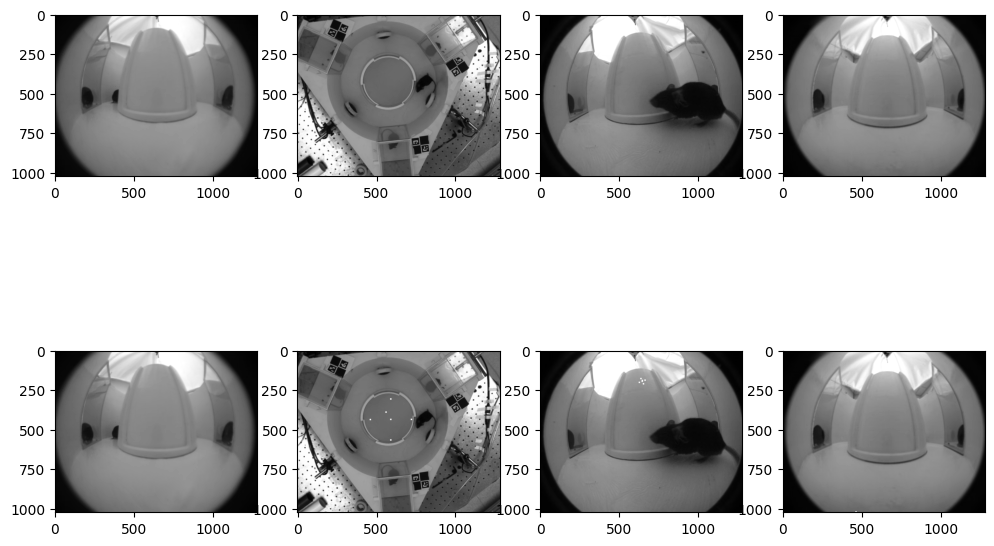

In [ ]:
world_points = world_points.view(-1,1,3)
for i in range(len(cams)):
    rvec = torch.zeros(3,dtype=torch.double,device=device)
    tvec = torch.zeros(3,dtype=torch.double,device=device)
    if i != 1:
        k = i
        if i > 0:
            k -= 1
        rvec = last_params[(k*6):(k*6)+3].clone()
        tvec = last_params[(k*6)+3:(k*6)+6].clone()
    cam = cams[i]
    K = utils.to_numpy(cam.get_K())
    D = utils.to_numpy(cam.get_D())
    proj_points = project(world_points, rvec,tvec,K,D,cam.fisheye)
    proj_pics[i] = draw_squares(proj_points, proj_pics[i])
to_display = np.concatenate((pics, proj_pics), axis=0)
display_pics(to_display, shape=[2,4], color="gray")